## 3 задание Бабушкиной Татьяны М05-012б

In [25]:
# positions:
#              L(EFT)    M(IDDLE)    R(IGHT)
#                           MT
# T(OP)      LT +-----------+-----------+ RT
#               |                       |
# M(IDDLE)   LM +                       + RM
#               |                       |
# B(OTTOM)   LB +-----------+-----------+ RB
#                           MB
POS_XMASK = 0b1100
POS_YMASK = 0b0011
POS_R  = 0b0000
POS_MX = 0b0100
POS_L  = 0b1000
POS_B  = 0b00
POS_MY = 0b01
POS_T  = 0b10
POS_RB = POS_R  | POS_B  # 0
POS_RM = POS_R  | POS_MY # 1 
POS_RT = POS_R  | POS_T  # 2 
POS_MT = POS_MX | POS_T  # 6
POS_LT = POS_L  | POS_T  # 10
POS_LM = POS_L  | POS_MY # 9
POS_LB = POS_L  | POS_B  # 8
POS_MB = POS_MX | POS_B  # 4
legal_positions = {POS_RB, POS_RM, POS_RT, POS_MT, POS_LT, POS_LM, POS_LB, POS_MB}


# a, b: centerX, centerY, width, height
def areRectanglesIntersect(a, b):
   return abs(a[0]-b[0]) < abs(a[2]+b[2])/2 and abs(a[1]-b[1]) < abs(a[3]+b[3])/2


# label: pointX, pointY, labelSize_X, labelSize_Y
def label2rectangle(label, pos):
	x = 0
	y = 0
	if pos&POS_XMASK == POS_R:
		x = label[0] - label[2]/2
	elif pos&POS_XMASK == POS_MX:
		x = label[0]
	elif pos&POS_XMASK == POS_L:	
		x = label[0] + label[2]/2
	else:
		raise NameError('invalid label position')
	
	if pos&POS_YMASK == POS_B:
		y = label[1] + label[3]/2
	elif pos&POS_YMASK == POS_MY:
		y = label[1]
	elif pos&POS_YMASK == POS_T:
		y = label[1] - label[3]/2
	else:
		raise NameError('invalid label position')
	
	return [x, y, label[2], label[3]]


def areLabelsIntersect(label1, pos1, label2, pos2):
	return areRectanglesIntersect(label2rectangle(label1, pos1), label2rectangle(label2, pos2))


# обозначения:можную пози
# положительное число i: берем 1-ю возможную позицию метки (i-1),
# отрицательное -- вторую (отрицание соотв. булевой переменной)
# label = [point_X point_Y labelSize_X labelSize_Y pos1 pos2]
def getClauses(labels):
	result = []
	for i in range(len(labels)):
		for j in range(len(labels)):
			if i != j:
				i1 = i+1
				j1 = j+1
				if areLabelsIntersect(labels[i], labels[i][4], labels[j], labels[j][4]):
					result.append((-i1, -j1))
				if areLabelsIntersect(labels[i], labels[i][4], labels[j], labels[j][5]):
					result.append((-i1, j1))
				if areLabelsIntersect(labels[i], labels[i][5], labels[j], labels[j][4]):
					result.append((i1, -j1))
				if areLabelsIntersect(labels[i], labels[i][5], labels[j], labels[j][5]):
					result.append((i1, j1))
	return result


def DFS(v, visited, graph):
	if v in visited:
		return []
	visited.add(v)
	output = []
	for w in graph[v]:
		output += DFS(w, visited, graph)
	output.append(v)
	return output


def strongly_connected_components(v, components, visited, reverseGraph):
	if v in visited:
		return components
	visited.add(v)
	if -v in components:
		raise Exception()
	# если переменная входит в тот же компонент, что отрицание, то решение не существует
	if v not in components:
		components[v] = True
	for w in reverseGraph[v]:
		strongly_connected_components(w, components, visited, reverseGraph)
	return components


def TwoSAT(Q, n):
	"""Calculate 2SAT for query Q with n variables.
	Returns None if no solution, else an object with variable index as key and
	boolean as value."""

	# строим граф и обратный граф
	# V = множество переменных в формуле и их отрицаний
   # E = {(~u, v),(~v,u) | для всех дизъюнктов [u,v] }
	graph = []
	reverseGraph = []
	for i in range((n+1)*2):
		graph.append([])
		reverseGraph.append([])
	for (a, b) in Q:
		graph[-a].append(b)
		graph[-b].append(a)
		reverseGraph[a].append(-b)
		reverseGraph[b].append(-a)

	#  вычисляем сильно связанные компоненты графа по алгоритму Косарайю
	# https://en.wikipedia.org/wiki/Kosaraju%27s_algorithm
	visited = set()
	L = []
	for i in range(n):
		L += DFS(i+1, visited, graph)
		L += DFS(-(i+1), visited, graph)
	L = L[::-1]

	visited = set()
	components = []
	try:
		for v in L:
			components.append(strongly_connected_components(v, {}, visited, reverseGraph))
	except:
		return
	
	# 3. prepare result
	result = {}
	while len(result) < n:
		c = components.pop()
		for p in c:
			if abs(p) not in result:
				result[abs(p)] = p > 0
	return result

## Приведем пример возможного расположения подписей

In [26]:
data = [
    [1.0, 1.0, 2.0, 2.0, 8, 9],
    [4.0, 1.0, 2.0, 2.0, 0, 8]
]


In [27]:
# каждой подписи сопоставляем переменную, которая ложна, если берется первая позиция, и верна, если вторая.
# для каждой пары подписей для каждой позиции проверяем, пересекаются или нет.
# если да, то получаем условие в SAT вида not(p and q) = (not p or not q), где p, q -- булевы переменные, задающие позиции двух подписей (возможно, с отрицанием)
# результат: 2-SAT формула
clauses = getClauses(data)
print("Clauses")
print(clauses)

Clauses
[(-1, -2), (1, -2), (-2, -1), (-2, 1)]


In [28]:
# решаем формулу
solution = TwoSAT(clauses, len(data))
if solution == None:
	print("No solution")
else:
	print("Solution")
	for idx, label in enumerate(data):
		if solution[idx+1]:
			print([label[0], label[1], label[2], label[3], label[4]])
		else:
			print([label[0], label[1], label[2], label[3], label[5]])

Solution
[1.0, 1.0, 2.0, 2.0, 8]
[4.0, 1.0, 2.0, 2.0, 8]


## Отрисуем полученное расположение подписей

(0.0, 6.0)

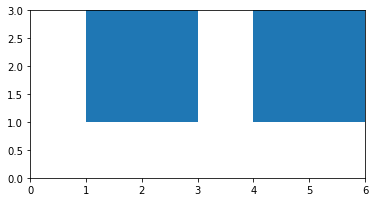

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
x_min = 0
y_min = 0
x_max = 0
y_max = 0
for idx, label in enumerate(data):
	r = label2rectangle(label, label[4]) if solution[idx+1] else label2rectangle(label, label[5])
	if r[0]+r[2]/2 > x_max:
		x_max = r[0]+r[2]/2
	if r[0]-r[2]/2 < x_min:
		x_min = r[0]-r[2]/2
	if r[1]+r[3]/2 > y_max:
		y_max = r[1]+r[3]/2
	if r[1]-r[3]/2 < y_min:
		y_min = r[1]-r[3]/2
	ax1.add_patch(patches.Rectangle((r[0]-r[2]/2, r[1]-r[3]/2), r[2], r[3]))

plt.ylim((y_min, y_max))
plt.xlim((x_min, x_max))

## Приведем пример невозможного расположения подписей

In [30]:
data = [
    [1.0, 1.0, 2.0, 2.0, 8, 9],
    [4.0, 1.0, 2.0, 2.0, 0, 1]
]
clauses = getClauses(data)
print("Clauses")
print(clauses)

solution = TwoSAT(clauses, len(data))
if solution == None:
	print("No solution")
else:
	print("Solution")
	for idx, label in enumerate(data):
		if solution[idx+1]:
			print([label[0], label[1], label[2], label[3], label[4]])
		else:
			print([label[0], label[1], label[2], label[3], label[5]])

Clauses
[(-1, -2), (-1, 2), (1, -2), (1, 2), (-2, -1), (-2, 1), (2, -1), (2, 1)]
No solution
